In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torchvision

from curriculum_deeplab.data_parameters import DataParamMode, DataParamOptim
from curriculum_deeplab.data_parameters import DataParameterManager

In [12]:
torchvision.datasets.MNIST(root="../data", download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

In [13]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
config = dotdict({
    # Data parameter config
    'data_param_mode': DataParamMode.ONLY_INSTANCE_PARAMS,
    'init_class_param': 1.0, 
    'lr_class_param': 0.1,
    'init_inst_param': 1.0, 
    'lr_inst_param': 0.1,
    'wd_inst_param': 0.0,
    'wd_class_param': 0.0,
    
    'skip_clamp_data_param': False,
    'clamp_sigma_min': np.log(1/20),
    'clamp_sigma_max': np.log(20),
    'optim_algorithm': DataParamOptim.ADAM,
    'optim_options': dict(
        # momentum=.9
        betas=(0.9, 0.999)
    )
})

torch.Size([958, 28, 28])


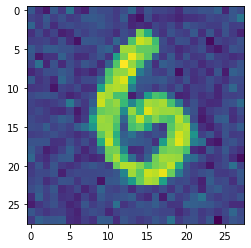

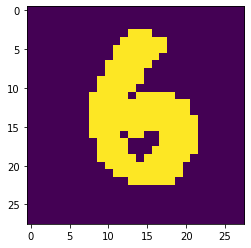

In [14]:
data = torch.from_numpy(scipy.io.loadmat('../data/mnist-six.mat')['data']).float()
segment = (data>150).long()
segment2 = (data>5).long()


image = (data/255 + torch.randn_like(data)*.1).unsqueeze(1)
print(data.shape)
plt.imshow(image[152,0].data.cpu())
plt.show()
plt.imshow(segment2[152].cpu())

In [15]:
do_flip = torch.rand(800)>0.7#[::2]
# do_flip = torch.rand(800)>0.0#[::2]
idx_flip = torch.empty(0).long()
for i in range(800):
    if(do_flip[i]):
        idx_flip = torch.cat((idx_flip,torch.tensor([i])))
        segment[i] = torch.roll(segment2[i].transpose(-2,-1),(int(torch.randn(1)*5),int(torch.randn(1)*5)),(0,1))

tensor([0, 1])


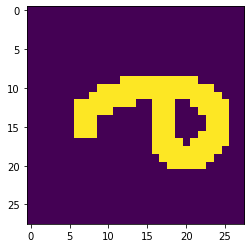

In [16]:
plt.imshow(segment[idx_flip[0]].cpu())
print(segment[0].unique())

In [37]:
net = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))


embedding = nn.Embedding(800, 1, sparse=True)
embedding
run_loss_mattias = torch.zeros(500)
run_cc_mattias = torch.zeros(500)

net = net.cuda()
embedding = embedding.cuda()
image = image.cuda()
segment = segment.cuda()
run_loss_mattias = run_loss_mattias.cuda()
run_cc_mattias = run_cc_mattias.cuda()
do_flip = do_flip.cuda()


optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
optimizer_data = torch.optim.SparseAdam(embedding.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer.zero_grad()
    optimizer_data.zero_grad()

    input = image[idx]
    output = net(input)

    loss_mattias = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean(-1).mean(-1)
    
    run_cc_mattias[i] = np.corrcoef(torch.sigmoid(embedding.weight).cpu().data.squeeze().numpy(),do_flip.float().cpu().numpy())[0,1]
    run_loss_mattias[i] = (loss_mattias*(1-do_flip[idx].float())).mean().item()

    # print(loss)
    weight = torch.sigmoid(embedding(idx)).squeeze()
    weight = weight/weight.mean()
    
    (loss_mattias*weight).sum().backward()
    optimizer.step()
    optimizer_data.step()

0
50
100
150
200
250
300
350
400
450


In [38]:
# Setup data parameter manager
CLASSES = ['background', 'six']
dpm = DataParameterManager(instance_keys=range(800), class_keys=CLASSES, config=config, device='cuda')

net2 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))

optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

run_loss2 = torch.zeros(500)
run_cc2 = torch.zeros(500)

image = image.cuda()
segment = segment.cuda()
net2 = net2.cuda()
run_loss2 = run_loss2.cuda()
run_cc2 = run_cc2.cuda()
do_flip = do_flip.cuda()

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()

    optimizer2.zero_grad()

    # Alt impl
    _input = image[idx]
    logits2 = net2(_input)
    logits2 = logits2.permute(0,2,3,1)
    _, loss = dpm.do_basic_train_step(
        nn.BCEWithLogitsLoss(), 
        logits2, 
        torch.nn.functional.one_hot(segment[idx].long()), 
        optimizer2, 
        inst_keys=idx.tolist(),
        scaler=None)

    run_cc2[i] = torch.tensor(np.corrcoef(torch.sigmoid(dpm.get_parameter_tensor(inst_keys=range(800))).detach().cpu().numpy(), do_flip.float().cpu().numpy()))[0,1]
    run_loss2[i] = (loss*(1-do_flip[idx].float())).mean().item()

Initialized instance data parameters with: 1.0
0
50
100
150
200
250
300
350
400
450


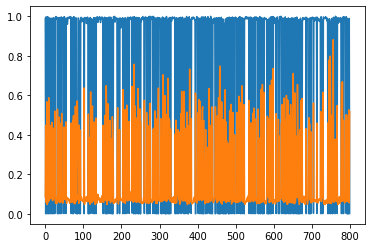

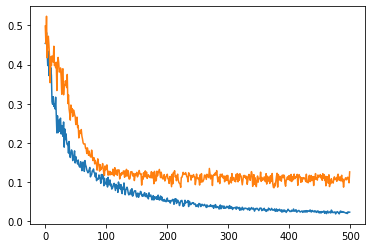

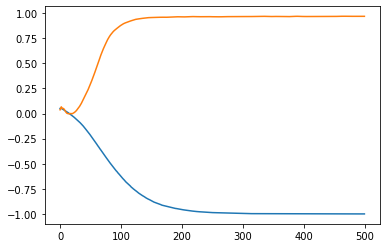

In [39]:
plt.plot(torch.sigmoid(embedding.weight.data.cpu()))
plt.plot(torch.sigmoid(dpm.get_parameter_tensor(inst_keys='all')).detach().cpu().numpy())
plt.show()

plt.plot(run_loss_mattias.cpu())
plt.plot(run_loss2.cpu())
plt.show()

plt.plot(run_cc_mattias.cpu())
plt.plot(run_cc2.cpu())
plt.show()

In [ ]:
#plt.plot(torch.sigmoid(embedding.weight).cpu().data.squeeze().numpy(),do_flip.float().numpy(),'.')